In [1]:
import os
import numpy as np
from os import path
import pandas as pd
from itertools import combinations
import pylab as pl
import time 
from sklearn.preprocessing import PolynomialFeatures


#Funcion de distancia 1/4

In [2]:
VARIABLES = [
    "ozone",
    "radiation",
    "wind",
    "temperature"
]

In [3]:
paths = [
    "Resultados",
    "Data",
    "images"
]
def crearPaths(paths=paths):
    for p in paths:    
        if not path.exists(f"{os.getcwd()}/{p}"):
            os.mkdir(f"{os.getcwd()}/{p}")
crearPaths()




In [4]:
#Separo el dataset en los x y

df_data = pd.read_csv("./dataset.csv", index_col="index")
ozono = df_data["ozone"]
df_vars = df_data.drop("ozone", axis=1)

df_vars.to_csv("Data/variables.csv")
ozono.to_csv("Data/ozono.csv")
df_vars.head()

,X,radiation,temperature,wind
index,,,,
1,1,190,67,7.4
2,2,118,72,8.0
3,3,149,74,12.6
4,4,313,62,11.5
5,5,299,65,8.6


In [5]:
#le aplica la tricubica a un array
def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y

In [78]:
def estandarizar(variable):
	esperanza = np.mean(variable)
	var = np.var(variable)
	if var == 0.0  :
		return variable
	else:
		return (variable - esperanza)/var

def desestandarizar(variable, valor):
	esperanza = np.mean(variable)
	var = np.var(variable)
	return valor*var + esperanza



In [7]:
def euclideanDistances(punto, array_de_puntos):
    results = []
    for punto_del_array in array_de_puntos:
        diferencia =  punto_del_array - punto
        distancia = np.linalg.norm(diferencia)
        results.append(distancia) 
    return np.array(results)


In [8]:

class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    
    def normalize_matrix(self, matrix):
        return np.array(list(map(self.normalize_array, matrix)), dtype=object).transpose()

    def __init__(self, xx, yy, degree=1):
        self.n_vars_xx, self.array_mins_xx, self.array_maxs_xx = self.normalize_matrix(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

        self.n_vars_xx = np.array(list(self.n_vars_xx)).transpose()
        # print(self.n_vars_xx)
        # print(self.array_mins_xx)
        # print(self.array_maxs_xx)

    @staticmethod
    def get_min_idx_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
            
        if min_idx == n-1:
            return np.arange(n - window, n)
            
        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        
        return np.array(min_range)
    

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return np.array(weights)

    def normalize_x(self, array_of_values):
        return (array_of_values - self.array_mins_xx) / (self.array_maxs_xx - self.array_mins_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, degree=1):
        n_x = self.normalize_x(x)
        distances = euclideanDistances(n_x, self.n_vars_xx)
        min_idx_range = self.get_min_idx_range(distances, window )
        weights = self.get_weights(distances, min_idx_range)
        wm = np.multiply(np.eye(window), weights)
        
        poly = PolynomialFeatures(degree)
        xp = n_x.reshape(1,-1)
        xp = poly.fit_transform(xp)

        xm = self.n_vars_xx[min_idx_range]
        xm = poly.fit_transform(xm)

        ym = np.array(list(self.n_yy[min_idx_range]))
        # print(ym)
        
        xmt = np.transpose(xm)
        xmt_wm = xmt @ wm
        # print(xmt_wm)
        
        beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
        # print(beta)
    
        y = (beta @ xp.transpose())

        return self.denormalize_y(y)


def main():
    xx = np.genfromtxt("Data/variables.csv", delimiter=",", skip_header=1, usecols=(2,3,4))
    yy = np.genfromtxt("Data/ozono.csv", delimiter=",", skip_header=1, usecols=(1))
    
    
    xx = np.array(list(map(estandarizar, xx.transpose()))) #lo trasponemos una sola vez
    
    est_y = estandarizar(yy) 
    loess = Loess(xx, est_y)  
    print("Original: ", yy[0])
    predicciones = []
    for x in xx.transpose():
        y = loess.estimate(x, window=44, degree=1)
        print(float(desestandarizar(yy, y)))
        break
        predicciones.append(float(desestandarizar(yy, y)))
        
    df_resultado = pd.DataFrame(predicciones, columns=["predicciones"])
    df_resultado.to_csv("./Resultados/predicciones_base.csv")
    

if __name__ == "__main__":
    start = time.time()

    main()

    end = time. time()
    #print(end - start)
    #print(end - start)

Original:  41.0
38.39957635549341


In [9]:
def estimarLoess(variablesEntrada, useColsEntrada, variableSalida, archivoSalida, f, grado, estandarizar_y=True):
    xx = np.genfromtxt(variablesEntrada, delimiter=",", skip_header=1, usecols=useColsEntrada)
    yy = np.genfromtxt(variableSalida, delimiter=",", skip_header=1, usecols=1)


    num_variables = 1
    if isinstance(useColsEntrada,int):
        xx = np.array([xx])
        xx = np.array(list(map(estandarizar, xx)))
    else: 
        xx = np.array(list(map(estandarizar, xx.transpose())))
        num_variables = len(useColsEntrada)
    
    est_y = yy
    if estandarizar_y :
        est_y = estandarizar(yy) 
    
    loess = Loess(xx, est_y) 
    q = int(np.round(f*(xx.size/num_variables)))
    predicciones = []
    
    for x in xx.transpose():
        y = loess.estimate(x, window=q, degree=grado)
        des_est_y = y
        if estandarizar_y :
            des_est_y = float(desestandarizar(yy, y))
        predicciones.append(des_est_y)
                
    df_resultado = pd.DataFrame(predicciones, columns=["predicciones"])
    df_resultado.to_csv(archivoSalida)

In [10]:
variablesPath = "Data/variables.csv"
ozonoPath = "Data/ozono.csv"

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Primer experimento con f = .4 lineal

In [12]:
def estimarConVariableSingular(variable_Path, aEstimar_Path, estimados_Path):
    
    estimarLoess(variable_Path, (1), aEstimar_Path, estimados_Path, 2/3, 1, estandarizar_y=False)

    variable = np.genfromtxt(variable_Path, delimiter=",", skip_header=1, usecols=(1))
    estimados = np.genfromtxt(estimados_Path, delimiter=",", skip_header=1, usecols=(1))

    #Ordenamos los residuales estimados a partir del ozono estimado
    variable_contra_estimados = pd.DataFrame({'Variable' : variable, 'Estimados' : estimados})
    variable_contra_estimados = variable_contra_estimados.sort_values(by='Variable')
    return variable_contra_estimados

In [13]:
#Estimamos el ozono con f = .4
resultadosPunto4Path = './Resultados/f=.4-lineal-ozono.csv'
estimarLoess(variablesPath, (2,3,4), ozonoPath, resultadosPunto4Path, .4, 1)

ozono_estimado = np.genfromtxt(resultadosPunto4Path, delimiter=",", skip_header=1, usecols=(1))
ozono_real = np.genfromtxt(ozonoPath, delimiter=",", skip_header=1, usecols=(1))

#Calculamos los residuales entre ozono real y estimado
diferencia_ozono =  ozono_real - ozono_estimado
diferencia_abs_ozono = np.abs(diferencia_ozono)

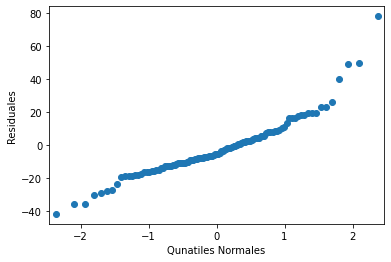

In [14]:
diferencia_ozono_ordenada = diferencia_ozono
diferencia_ozono_ordenada.sort()
fig = sm.qqplot(diferencia_ozono_ordenada)
plt.xlabel('Qunatiles Normales')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-quantiles-f=punto4.svg')

In [15]:
#estimamos los residuales en base al ozono estimado
residuales_df = pd.DataFrame({'residuales' : diferencia_abs_ozono})
residuales_path = './Resultados/f=.4-lineal-residuales.csv'
residuales_df.to_csv(residuales_path)

residuales_contra_ozono_estimado = estimarConVariableSingular(resultadosPunto4Path, residuales_path, './Resultados/f=.66-lineal-ResidualesxOzono.csv')

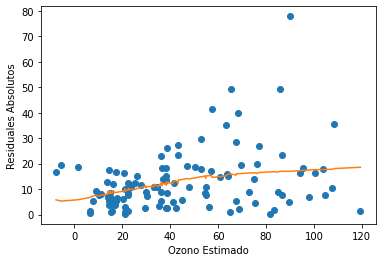

In [16]:

fig = plt.plot(ozono_estimado, diferencia_abs_ozono, 'o')
plt.plot(residuales_contra_ozono_estimado.Variable, residuales_contra_ozono_estimado.Estimados)
plt.xlabel('Ozono Estimado')
plt.ylabel('Residuales Absolutos')
plt.savefig('./images/Residuales-contra-ozono-f=punto4.svg')

In [17]:
residuales_noAbs_df = pd.DataFrame({'residuales' : diferencia_ozono})
residuales_noAbs_path = './Resultados/f=.4-lineal-residuales_noAbs.csv'
residuales_noAbs_df.to_csv(residuales_noAbs_path)

df_radiacion = df_vars.drop('temperature', axis=1).drop('wind', axis=1).drop('X', axis=1).reset_index(drop=True)
radiacion_path = './Data/radiacion.csv'
df_radiacion.to_csv(radiacion_path)

residuales_contra_radiacion = estimarConVariableSingular(radiacion_path, residuales_path, './Resultados/f=.66-lineal-ResidualesxRadiacion.csv')

df_temperatura = df_vars.drop('radiation', axis=1).drop('wind', axis=1).drop('X', axis=1).reset_index(drop=True)
temperatura_path = './Data/temperatura.csv'
df_temperatura.to_csv(temperatura_path)

residuales_contra_temperatura = estimarConVariableSingular(temperatura_path, residuales_path, './Resultados/f=.66-lineal-ResidualesxTemperatura.csv')

df_viento = df_vars.drop('temperature', axis=1).drop('radiation', axis=1).drop('X', axis=1).reset_index(drop=True)
viento_path = './Data/viento.csv'
df_viento.to_csv(viento_path)

residuales_contra_viento = estimarConVariableSingular(viento_path, residuales_path, './Resultados/f=.66-lineal-ResidualesxViento.csv')

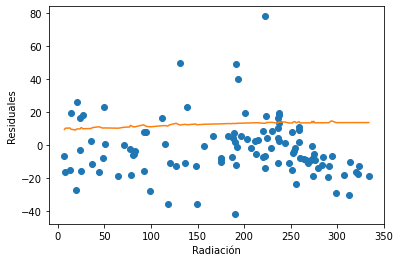

In [18]:
fig = plt.plot(df_radiacion.radiation, diferencia_ozono, 'o')
plt.plot(residuales_contra_radiacion.Variable, residuales_contra_radiacion.Estimados)
plt.xlabel('Radiación')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-radiacion-f=punto4.svg')

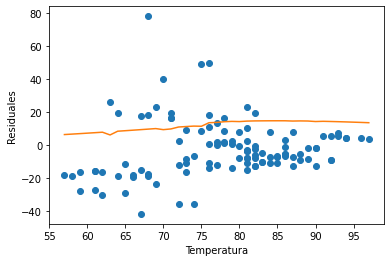

In [19]:
fig = plt.plot(df_temperatura.temperature, diferencia_ozono, 'o')
plt.plot(residuales_contra_temperatura.Variable, residuales_contra_temperatura.Estimados)
plt.xlabel('Temperatura')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-temperatura-f=punto4.svg')

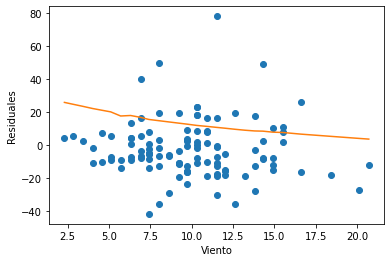

In [20]:
fig = plt.plot(df_viento.wind, diferencia_ozono, 'o')
plt.plot(residuales_contra_viento.Variable, residuales_contra_viento.Estimados)
plt.xlabel('Viento')
plt.ylabel('Residuales')
plt.savefig('./images/Residuales-contra-viento-f=punto4.svg')

# Segunda parte de la experimentacion: 
estimar la raiz cúbica del ozono con valores fijos para dos variables, con f=.8 localmente cuadratico

In [85]:
def estandarizarAPartirDe(variableComp, variableSinEst):
    media = np.mean(variableComp)
    var = np.var(variableComp)
    return (variableSinEst - media)/var

def estandarizarVariablesAPartirDe(variablesComp, variablesSinEst):
    rad_comp = variablesComp.transpose()[0]
    rad_sinEst = variablesSinEst.transpose()[0]
    rad_est = estandarizarAPartirDe(rad_comp, rad_sinEst)

    temp_comp = variablesComp.transpose()[1]
    temp_sinEst = variablesSinEst.transpose()[1]
    temp_est = estandarizarAPartirDe(temp_comp, temp_sinEst)

    viento_comp = variablesComp.transpose()[2]
    viento_sinEst = variablesSinEst.transpose()[2]
    viento_est = estandarizarAPartirDe(viento_comp, viento_sinEst)

    return np.array([rad_est, temp_est, viento_est]).transpose()

In [108]:
def estimarLoessOzono(variablesEntrada, variableAEstimar, variablesParaEstimar):
    xx = variablesEntrada
    yy = variableAEstimar


    xx = np.array(list(map(estandarizar, xx.transpose())))
    est_y = estandarizar(yy) 
    

    loess = Loess(xx, est_y) 
    q = int(np.round(.8*(xx.size/3)))
    predicciones = []

    for i in range(0,3):
        ps = []
        for j in range(0,3):
            pss = []
            variables_est = estandarizarVariablesAPartirDe(variablesEntrada, variablesParaEstimar[i][j])
            for x in variables_est:
                y = loess.estimate(x, window=q, degree=2)
                des_est_y = float(desestandarizar(yy, y))
                pss.append(des_est_y)
            ps.append(np.array(pss))
        predicciones.append(np.array(ps))
                
    return np.array(predicciones)

In [117]:
valores_fijos_viento = np.array([5,10,15])
valores_fijos_radiacion = np.array([50,170,290])
valores_fijos_temperatura = np.array([62,76,90])

valores_variables_viento = range(1,21)
valores_variables_temperatura = range(60, 101, 2)
valores_variables_radiacion = range(1, 361, 18)


raiz_cubica_ozono = np.cbrt(ozono_real)
variables_reales = np.genfromtxt(variablesPath, delimiter=",", skip_header=1, usecols=(2,3,4))

variables_viento = []
for rad in valores_fijos_radiacion :
    ls = []
    for temp in valores_fijos_temperatura:
        lls = []
        for viento in valores_variables_viento:
            lls.append(np.array([rad,temp,viento]))
        
        ls.append( np.array(lls) ) 

    variables_viento.append(np.array(ls))
variables_viento = np.array(variables_viento)

variables_temperatura = []
for rad in valores_fijos_radiacion :
    ls = []
    for viento in valores_fijos_viento:
        lls = []
        for temp in valores_variables_temperatura:
            lls.append(np.array([rad,temp,viento]))
        
        ls.append( np.array(lls) ) 

    variables_temperatura.append(np.array(ls))
variables_temperatura = np.array(variables_temperatura)

variables_radiacion = []
for temp in valores_fijos_temperatura:
    ls = []
    for viento in valores_fijos_viento:
        lls = []
        for rad in valores_variables_radiacion :
            lls.append(np.array([rad,temp,viento]))
        
        ls.append( np.array(lls) ) 

    variables_radiacion.append(np.array(ls))
variables_radiacion = np.array(variables_radiacion)


In [109]:
estimacionOzono_viento = estimarLoessOzono(variables_reales, raiz_cubica_ozono, variables_viento)
estimacionOzono_radiacion = estimarLoessOzono(variables_reales, raiz_cubica_ozono, variables_radiacion)
estimacionOzono_temperatura = estimarLoessOzono(variables_reales, raiz_cubica_ozono, variables_temperatura)

In [110]:
def plotear3x3(primeraVariableFija, valoresFijosPrimera, segundaVariableFija, valoresFijosSegunda, variable, valores_variables, valores_ozono):
    fig, axes = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(segundaVariableFija)
    fig.supylabel('Raiz Cúbica Ozono')
    fig.supxlabel(variable)

    axes[0][0].set_title(valoresFijosSegunda[0])
    axes[0][1].set_title(valoresFijosSegunda[1])
    axes[0][2].set_title(valoresFijosSegunda[2])

    axes[0][2].set_ylabel( primeraVariableFija +': '+ str(valoresFijosPrimera[2] ))
    axes[0][2].yaxis.set_label_position("right")
    axes[1][2].set_ylabel( primeraVariableFija +': '+ str(valoresFijosPrimera[1] ))
    axes[1][2].yaxis.set_label_position("right")
    axes[2][2].set_ylabel( primeraVariableFija +': '+ str(valoresFijosPrimera[0] ))
    axes[2][2].yaxis.set_label_position("right")

    for i in range(0,3):
        for j in range(0,3):
            sns.lineplot(ax=axes[i][j], x=valores_variables, y=valores_ozono[2-i][j])
            axes[i][j].set_yticks([1,3,4,5,7])

    plt.savefig('./images/valores-fijos-y-'+variable+'.svg')

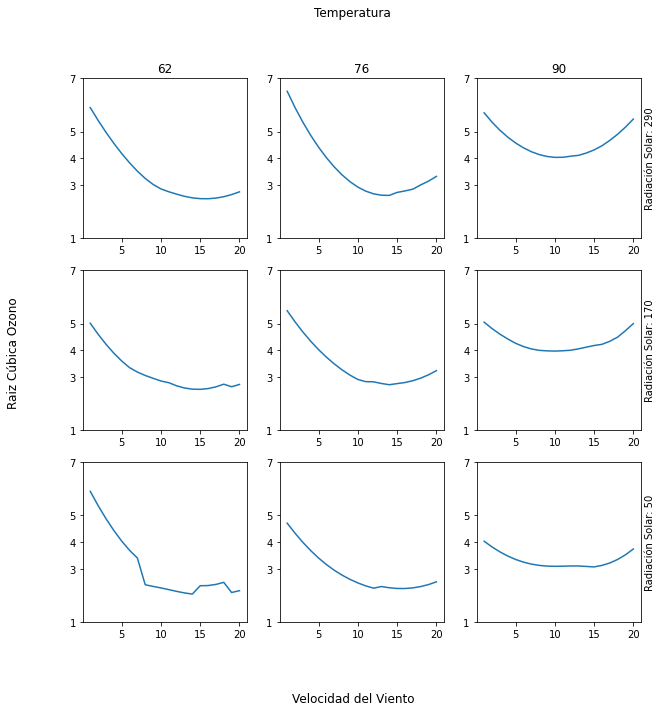

In [111]:
plotear3x3('Radiación Solar', valores_fijos_radiacion, 'Temperatura', valores_fijos_temperatura, 'Velocidad del Viento', valores_variables_viento, estimacionOzono_viento)

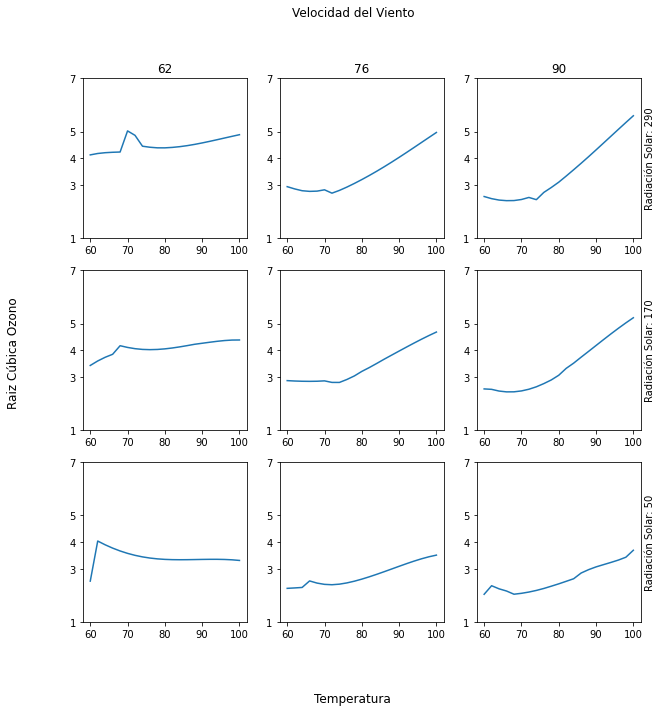

In [112]:
plotear3x3('Radiación Solar', valores_fijos_radiacion, 'Velocidad del Viento', valores_fijos_temperatura, 'Temperatura', valores_variables_temperatura, estimacionOzono_temperatura)

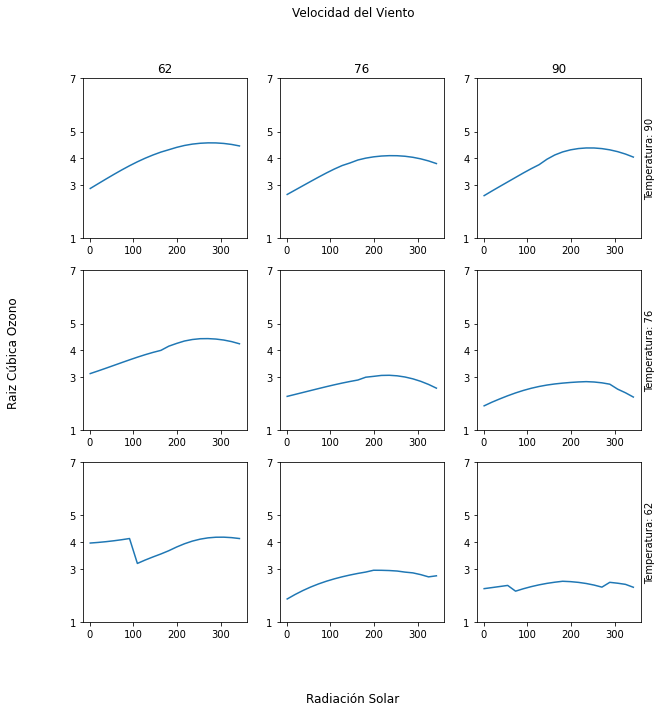

In [113]:
plotear3x3('Temperatura', valores_fijos_temperatura, 'Velocidad del Viento', valores_fijos_temperatura, 'Radiación Solar', valores_variables_radiacion, estimacionOzono_radiacion)